In [3]:
import time
import xraydb as xdb
import numpy as np
from pySWXF.fluor_fit import multilayer_model_Ti
import pickle 
from matplotlib import pyplot as pltk
from pathlib import Path
      

In [15]:
data_dir = Path("../data_archive")
result_dir = Path("../result_archive")
plot_dir = Path("../figure_archive")
fname = "multilayer_May_2023.pickle"
file_path = data_dir / fname  
result_path = data_dir 
with open(file_path,'rb') as fd:
    data = pickle.load(fd)
th = data['th']
I = data['I']
dI = data['dI']
dI[dI==0]=np.min(dI[dI>0])  # get rid of zero error bars

In [11]:
from lmfit import Parameters

params = Parameters()

# Dictionary of parameter values
param_values = {
    "D": {"value": 45.72, "min": 45.0, "max": 45.8, "vary": True},
    "G": {"value": 0.66, "min": 0.5, "max": 0.7, "vary": True},
    "I0": {"value": 1, "min": 0.98, "max": 1.02, "vary": False},
    "bg": {"value": 0, "vary": False},
    "foot": {"value": 0, "vary": False},
    "overlay": {"value": 48, "min": 20, "max": 90, "vary": False},
    "sig_Si": {"value": 3.37, "min": 2, "max": 8, "vary": True},
    "sig_Mo": {"value": 7.33, "min": 2, "max": 8, "vary": True},
    "sig_Si_top": {"value": 3, "min": 2, "max": 6, "vary": False},
    "thoff": {"value": 0, "min": -0.005, "max": 0.005, "vary": False},
    "res": {"value": 0.005956, "min": 0.001, "max": 0.01, "vary": False},
    "D_Ti": {"value": 103.4, "min": 90, "max": 110, "vary": False},
    "sig_Ti": {"value": 3, "min": 2, "max": 8, "vary": False},
    "D_SiO2": {"value": 10, "min": 7, "max": 18, "vary": False},
    "sig_SiO2": {"value": 3, "min": 2, "max": 8, "vary": False},
    "D_SiO2_Bot": {"value": 30, "min": 15, "max": 50, "vary": False},
    "sig_SiO2_Bot": {"value": 3, "min": 1, "max": 9, "vary": False},
    "sig_Si_Bot": {"value": 3, "min": 1, "max": 9, "vary": False},
}

# Add parameters dynamically in a **single step**
for name, attrs in param_values.items():
    params.add(name, **attrs)

# Set energy value
Energy = xdb.xray_lines("Mo")["Ka1"][0]


In [16]:
# Start timer
tic = time.time()

# Define fitting window
fit_mask = (th > 0.05) & (th < 2)

# Perform first fit
result = multilayer_model_Ti.fit(
    I[fit_mask],
    params,
    theta=th[fit_mask],
    Energy=Energy,
    water=False,
    bilayer=False,
    weights=1 / dI[fit_mask],
    max_nfev=200,
)

# Update parameters after fit
params = result.params

# Print fit report
print(result.fit_report())

# Save fit report to file
fit_report_path = result_dir / "bare_multilayer_fit.txt"
with open(fit_report_path, "w") as f:
    f.write("First Fit\n")
    f.write("____________________________________________\n")
    f.write(result.fit_report())


[[Model]]
    Model(multilayer_ref_Ti)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 53
    # data points      = 466
    # variables        = 3
    chi-square         = 221235.083
    reduced chi-square = 477.829553
    Akaike info crit   = 2877.86271
    Bayesian info crit = 2890.29526
    R-squared          = 0.99551806
[[Variables]]
    D:             45.78702 (fixed)
    G:             0.6755463 (fixed)
    I0:            1 (fixed)
    bg:            0 (fixed)
    foot:          0 (fixed)
    overlay:       48.1870744 +/- 1.09716133 (2.28%) (init = 48)
    sig_Si:        3.340299 (fixed)
    sig_Mo:        7.412603 (fixed)
    sig_Si_top:    3 (fixed)
    thoff:         0 (fixed)
    res:           0.00576158 +/- 2.3251e-04 (4.04%) (init = 0.005956)
    D_Ti:          104.595404 +/- 1.59308418 (1.52%) (init = 103.4)
    sig_Ti:        3 (fixed)
    D_SiO2:        10 (fixed)
    sig_SiO2:      3 (fixed)
    D_SiO2_Bot:    30 (fixed)
    sig_SiO2_Bot:  

In [17]:
fit_mask = (th > 0.2) & (th < 0.43)

params_to_fix = ["D", "G", "thoff", "sig_SiO2", "sig_Ti", "sig_Si", "sig_Mo", "sig_Si_top"]
params_to_vary = ["overlay", "D_Ti", "res"]

for param in params_to_fix:
    params[param].vary = False  # Fix these parameters

for param in params_to_vary:
    params[param].vary = True   # Allow these to vary

# Perform the second fit
result = multilayer_model_Ti.fit(
    I[fit_mask],
    params,
    theta=th[fit_mask],
    Energy=Energy,
    water=False,
    bilayer=False,
    weights=1 / dI[fit_mask],
    max_nfev=5000,
)

# Compute elapsed time
toc = time.time()
print(f"\nFit completed in {toc - tic:7.3f} s\n")

# Define file paths
fit_report_path = result_dir / "bare_multilayer_fit.txt"
params_json_path = result_dir / "niu_multilayer_fit_params.json"

# Append fit results to text file
with open(fit_report_path, "a") as f:
    f.write("\n" + "-" * 50 + "\n")
    f.write("Second Fit\n")
    f.write("-" * 50 + "\n")
    f.write(result.fit_report())

# Save parameters as JSON
with open(params_json_path, "w") as f:
    result.params.dump(f)



Fit completed in  66.945 s



[[Model]]
    Model(multilayer_ref_Ti)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 91
    # variables        = 3
    chi-square         = 6924.22507
    reduced chi-square = 78.6843758
    Akaike info crit   = 400.204894
    Bayesian info crit = 407.737473
    R-squared          = 0.88542422
[[Variables]]
    D:             45.78702 (fixed)
    G:             0.6755463 (fixed)
    I0:            1 (fixed)
    bg:            0 (fixed)
    foot:          0 (fixed)
    overlay:       46.3754867 +/- 0.62849097 (1.36%) (init = 48.18707)
    sig_Si:        3.340299 (fixed)
    sig_Mo:        7.412603 (fixed)
    sig_Si_top:    3 (fixed)
    thoff:         0 (fixed)
    res:           0.00638863 +/- 3.5493e-04 (5.56%) (init = 0.005761576)
    D_Ti:          104.386669 +/- 1.30918314 (1.25%) (init = 104.5954)
    sig_Ti:        3 (fixed)
    D_SiO2:        10 (fixed)
    sig_SiO2:      3 (fixed)
    D_SiO2_Bot:    30 (fixed)
    sig_

(0.004, 1.2)

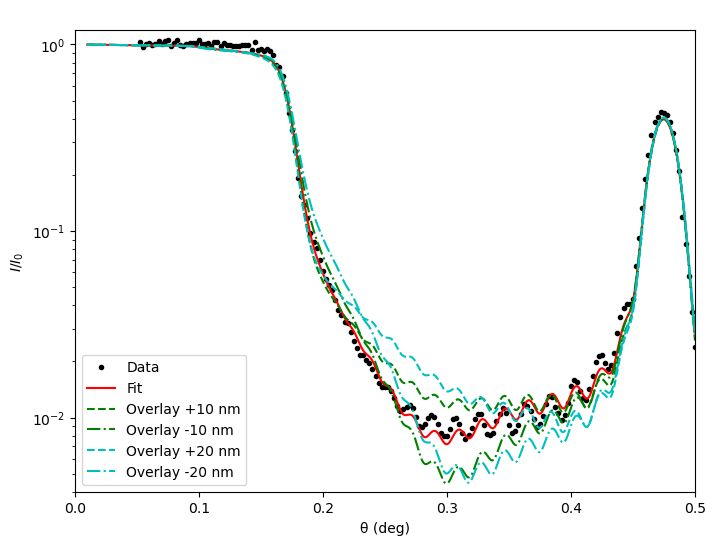

In [18]:
# Simulated theta values
thsim = np.linspace(0.01, 3, 10000)

# Evaluate fit with optimized parameters
fit = result.eval(theta=thsim, Energy=Energy, water=False, bilayer=False)

# Print final fit report
print(result.fit_report())

# Create figure
plt.figure("fit niu multilayer 1", figsize=(8, 6))
plt.clf()

# Plot experimental data and fitted curve
plt.plot(th, I, ".k", label="Data")
plt.plot(thsim, fit, "-r", label="Fit")

# Set log scale for better visualization
plt.yscale("log")

# Set labels and title
plt.xlabel("θ (deg)")
plt.ylabel(r"$I/I_0$")
plt.title(" ")

# Store original overlay value
par = result.params
bf_overlay = par["overlay"].value

# Define overlay shifts for additional simulations
overlay_shifts = [10, -10, 20, -20]
colors = ["g", "g", "c", "c"]
linestyles = ["--", "-.", "--", "-."]

# Generate and plot simulations with overlay variations
for shift, color, linestyle in zip(overlay_shifts, colors, linestyles):
    par["overlay"].value = bf_overlay + shift
    sim = multilayer_model_Ti.eval(theta=thsim, params=par, Energy=Energy, water=False, bilayer=False)
    plt.plot(thsim, sim, linestyle, color=color, label=f"Overlay {shift:+} nm")

# Restore original overlay value
par["overlay"].value = bf_overlay

# Add legend and save figures
plt.legend()

# Save plot files
plt.savefig(plot_dir / "niu_multilayer_fit_full.png")
plt.xlim(0, 0.5)
plt.ylim(0.001, 1.2)
plt.savefig(plot_dir / "niu_multilayer_fit_close.png")

# Reset plot for terminal use
plt.xlim(0, 0.5)
plt.ylim(4e-3, 1.2)

    